In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("Larger_Activities.csv")

#Clean Data First

#Date
data["Date"] = pd.to_datetime(data["Date"])
data = data[(data["Date"].dt.month >= 6) & (data["Date"].dt.month < 10)]

#Weekday and week columns
data["Weekday"] = data["Date"].dt.day_name()

data["Week_Start"] = data["Date"].dt.to_period("W-SUN").apply(lambda r: r.start_time)
data["Week"] = data["Week_Start"].rank(method="dense").astype(int)

#Dropping columns
data = data[["Date", "Week", "Weekday", "Distance", "Calories", "Time", "Avg HR", "Max HR", "Avg Pace", "Best Pace", "Total Ascent", "Total Descent", "Steps"]]
data.head()


,Date,Week,Weekday,Distance,Calories,Time,Avg HR,Max HR,Avg Pace,Best Pace,Total Ascent,Total Descent,Steps
5,2025-09-30 20:07:27,19,Tuesday,10.01,"1,243",1:17,165,190,7:40,5:36,62,72,"12,674"
6,2025-09-28 23:07:55,18,Sunday,8.56,"1,035",1:15,141,150,8:40,5:45,26,46,"11,904"
7,2025-09-27 10:21:20,18,Saturday,16.01,"1,944",2:11,153,177,8:09,6:36,230,203,"21,386"
8,2025-09-26 09:25:42,18,Friday,5.00,539,0:53,129,140,10:28,9:02,--,--,"8,338"
9,2025-09-25 11:48:47,18,Thursday,8.01,887,1:02,144,178,7:43,6:48,98,79,"10,314"


In [4]:
#Turning strings into numbers

data = data.copy()
cols = ["Distance", "Calories", "Steps", "Total Ascent", "Total Descent"]

for col in cols:
    data[col] = data[col].astype(str).str.replace(",","").replace("--", "0").astype(float)

#Time and Pace functions

def time_converter(str):
    h,m = str.split(":")
    h = int(h)
    m = int(m)
    total = (60*h) +m
    return total

def pace_converter(pace):
    m,s = pace.split(":")
    m = int(m)
    s = int(s)
    s = (s*(5/3))/100
    final_pace = m+s
    return round(final_pace,2)

data["Time"] = data["Time"].apply(time_converter)
data["Avg Pace"] = data["Avg Pace"].apply(pace_converter)
data["Best Pace"] = data["Best Pace"].apply(pace_converter)

#Change Distances due to some being meters
data.loc[data["Distance"] > 100, "Distance"] = round(data["Distance"] / 1609.34, 2)
#data.loc[rows_to_change, columns_to_change] = new_value

#Add months
data["Month"] = data["Date"].dt.month_name()
months_ordered = months_ordered = ["January", "February", "March", "April", "May", "June",
         "July", "August", "September", "October", "November", "December"]

data["Month"] = pd.Categorical(data["Month"], ordered=True, categories=months_ordered)

#Adding Zones
zone_bins = [0,120,145,160,175,200]
zone_labels = ["Zone 1", "Zone 2", "Zone 3", "Zone 4", "Zone 5"]
data["Zones"] = pd.cut(data["Avg HR"], bins=zone_bins, labels=zone_labels, right=False)

#Lastly drop columns
data = data[["Date", "Week", "Weekday", "Distance", "Calories", "Time", "Avg HR", "Max HR", "Avg Pace", "Best Pace","Zones", "Total Ascent", "Total Descent", "Steps"]]
data.head()


,Date,Week,Weekday,Distance,Calories,Time,Avg HR,Max HR,Avg Pace,Best Pace,Zones,Total Ascent,Total Descent,Steps
5,2025-09-30 20:07:27,19,Tuesday,10.01,1243.0,77,165,190,7.67,5.60,Zone 4,62.0,72.0,12674.0
6,2025-09-28 23:07:55,18,Sunday,8.56,1035.0,75,141,150,8.67,5.75,Zone 2,26.0,46.0,11904.0
7,2025-09-27 10:21:20,18,Saturday,16.01,1944.0,131,153,177,8.15,6.60,Zone 3,230.0,203.0,21386.0
8,2025-09-26 09:25:42,18,Friday,5.00,539.0,53,129,140,10.47,9.03,Zone 2,0.0,0.0,8338.0
9,2025-09-25 11:48:47,18,Thursday,8.01,887.0,62,144,178,7.72,6.80,Zone 2,98.0,79.0,10314.0


In [5]:
#Building the weekly table by aggreation and plotting

weekly_num = (data.groupby("Week", as_index=True)
              .agg(TotalMiles = ("Distance", "sum"), AvgPace = ("Avg Pace", "mean"))).sort_index()
weekly_num["AvgPace"] = weekly_num["AvgPace"].round(2)
#This is creating a new table grouping by Week making new columns using agg function

/var/folders/z5/sl5m8j4x253fdkftjccg38tw0000gn/T/ipykernel_5253/169297535.py:27: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax1.legend([bars, line], ["Total miles", "Avg pace"], loc="upper left")


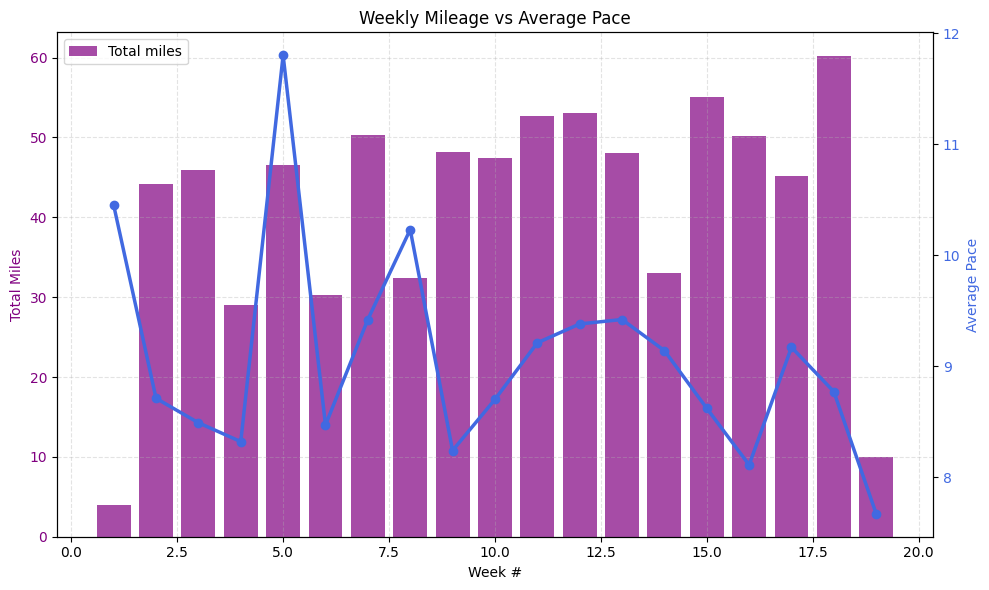

In [17]:
#Creates the figure and the set of x and y axes
fig, ax1 = plt.subplots(figsize=(10,6))

# Bars on the left axis = Total weekly miles
bars = ax1.bar(weekly_num.index, weekly_num["TotalMiles"],color="purple", alpha=0.7,label="Total Miles")
ax1.set_xlabel("Week #")
ax1.set_ylabel("Total Miles", color="purple")
ax1.tick_params(axis="y", labelcolor="purple")

# 3️⃣ Add second Axes sharing same x but with its own y-axis
ax2 = ax1.twinx()

line, = ax2.plot(
    weekly_num.index,
    weekly_num["AvgPace"],
    color="royalblue", linewidth=2.5, marker="o",
    label="Avg pace (min/mi)"
)
ax2.set_ylabel("Average Pace", color="royalblue")
ax2.tick_params(axis="y", labelcolor="royalblue")

# 4️⃣ Add title, grid, legend, layout tweaks
ax1.set_title("Weekly Mileage vs Average Pace")
ax1.grid(True, linestyle="--", alpha=0.35)
fig.tight_layout()

ax1.legend([bars, line], ["Total miles", "Avg pace"], loc="upper left")
